In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Import dependencies
import time
import math
import datetime
from collections import OrderedDict
from tqdm.auto import tqdm
from pathlib import Path
from thop import profile

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
import torch.nn.init as init

import mlflow
import random
import numpy as np
import psutil
import subprocess
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import warnings 
warnings.filterwarnings("ignore")

In [4]:
# torch.cuda.memory._record_memory_history()

In [5]:
def increment_path(path, exist_ok=False, sep='', mkdir=True):
    path = Path(path)
    if path.exists() and not exist_ok:
        path, suffix = (path.with_suffix(''), path.suffix) if path.is_file() else (path, '')
        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'
            if not os.path.exists(p):
                break
        path = Path(p)
    if mkdir:
        path.mkdir(parents=True, exist_ok=True)
    return path

In [6]:
EXPERIMENT_NAME = "exp"
FILE = Path(os.getcwd()).resolve()
SAVE_DIR = increment_path(FILE / "artifacts" / f"{EXPERIMENT_NAME}", exist_ok=False)
(SAVE_DIR / 'checkpoints').mkdir(parents=True, exist_ok=True)

In [7]:
local_tracking_uri = f"sqlite:///mlflow/mlflow.db"
mlflow.set_tracking_uri(local_tracking_uri)
mlflow.set_experiment(SAVE_DIR.stem)

2024/03/12 01:53:31 INFO mlflow.tracking.fluent: Experiment with name 'exp15' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/Hp/Desktop/mldev/2024/Git/mldevworld/Deep-Learning-Essentials/mlruns/15', creation_time=1710188611722, experiment_id='15', last_update_time=1710188611722, lifecycle_stage='active', name='exp15', tags={}>

In [8]:
def set_experiment_seed(seed=42):
    """
    Set random seeds and CUDA-related flags for experiment reproducibility.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # If using GPU, set random seed for CUDA operations
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  # Set to False for reproducibility

    # Optionally log seed information
    print(f"Random seed set to {seed}")

set_experiment_seed()

Random seed set to 42


In [9]:
# Download MNIST dataset
data_train = MNIST(
    "./data/mnist", download=True, 
    transform=transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=1),
        transforms.ToTensor()
    ])
)
        
data_test = MNIST(
    "./data/mnist", download=True, train=False,
    transform=transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
)

In [10]:
# Define hyperparameters
N_CLASSES = 10
EPOCHS = 5
BATCH_SIZE = 1609
DROPOUT_PROB = 	0.12931721102481436
USE_BATCHNORM = False
LABEL_SMOOTHING = 8.83890730090731e-07
LR = 0.028147621640854794
WARMUP_PROPORTION = 0.04584907346713653
WEIGHT_DECAY = 2.1415275778699216e-06
ACCUMULATION_STEPS = 1

In [11]:
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(data_train[i][0].permute(1,2,0).numpy(), cmap=plt.cm.binary)
#     plt.xlabel(data_train[i][1])
# plt.show()

`torch.utils.data.DataLoader` supports asynchronous data loading and data augmentation in separate worker subprocesses. The default setting for DataLoader is `num_workers=0`, which means that the data loading is synchronous and done in the main process. As a result the main training process has to wait for the data to be available to continue the execution.

Settin`g num_workers >` 0 enables asynchronous data loading and overlap between the training and data loading. num_workers should be tuned depending on the workload, CPU, GPU, and location of training data.`

DataLo`ader acce`pts pin_me`mory argument, which defaults` to F`alse. When using a GPU it’s better to `set pin_memory=`True, this instru`cts DataLo`ader to use pinned memory and enables faster and asynchronous memory copy from the host to the GPU.

In [12]:
def calculate_num_workers():
    # Calculate the number of CPU cores
    num_cpu_cores = os.cpu_count()

    # Set a safe maximum multiplier value (e.g., 0.5) to avoid using all available resources
    max_multiplier = 0.5

    # Calculate the number of workers based on the available resources
    multiplier = min(sum(psutil.cpu_percent(interval=1, percpu=True)) / 100.0, max_multiplier)
    
    # Ensure that num_workers is at least 1
    num_workers = max(1, int(num_cpu_cores * multiplier))

    return num_workers

In [13]:
# Define train dataloader
train_dataloader = DataLoader(
    data_train, batch_size=BATCH_SIZE, 
    sampler=RandomSampler(data_train), 
    pin_memory=True, num_workers=calculate_num_workers()
)

# Define test dataloader
test_dataloader = DataLoader(
    data_test, batch_size=BATCH_SIZE, 
    sampler=SequentialSampler(data_test),
    pin_memory=True, num_workers=calculate_num_workers()
)

`torch.nn.Conv2d()` has `bias` parameter which defaults to `True` (the same is true for `Conv1d` and `Conv3d` ).

If a `nn.Conv2d` layer is directly followed by a `nn.BatchNorm2d` layer, then the bias in the convolution is not needed, instead use `nn.Conv2d(..., bias=False, ....)`. Bias is not needed because in the first step `BatchNorm` subtracts the mean, which effectively cancels out the effect of bias.

This is also applicable to 1d and 3d convolutions as long as `BatchNorm`(or other normalization layer) normalizes on the same dimension as convolution’s bias.

In [14]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
                
        self.features1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(5, 5), bias=not USE_BATCHNORM),
            self._get_norm_layer(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Dropout2d(p=DROPOUT_PROB)
        )
        
        self.features2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=(5, 5), bias=not USE_BATCHNORM),
            self._get_norm_layer(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Dropout2d(p=DROPOUT_PROB)
        )

        self.features3 = nn.Sequential(
            nn.Conv2d(16, 120, kernel_size=(5, 5), bias=not USE_BATCHNORM),
            self._get_norm_layer(120),
            nn.ReLU(),
            nn.Dropout2d(p=DROPOUT_PROB)
        )

        self.classifier = nn.Sequential(
            nn.Linear(120, 84, bias=True),
            nn.ReLU(),
            nn.Dropout(p=DROPOUT_PROB),
            nn.Linear(84, 10, bias=True)
        )

        # Initialize layers
        self.apply(self._initialize_weights)

    def _get_norm_layer(self, channels):
        if USE_BATCHNORM:
            return nn.BatchNorm2d(channels)
        else:
            return nn.Identity()

    def _initialize_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            init.kaiming_uniform_(m.weight)
            if m.bias is not None:
                init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Instantiate the model
model = LeNet()
model = model.to(device)

# Test with a random input
summary(model, input_size=(1, 32, 32), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1609, 6, 28, 28]             156
          Identity-2          [1609, 6, 28, 28]               0
              ReLU-3          [1609, 6, 28, 28]               0
         MaxPool2d-4          [1609, 6, 14, 14]               0
         Dropout2d-5          [1609, 6, 14, 14]               0
            Conv2d-6         [1609, 16, 10, 10]           2,416
          Identity-7         [1609, 16, 10, 10]               0
              ReLU-8         [1609, 16, 10, 10]               0
         MaxPool2d-9           [1609, 16, 5, 5]               0
        Dropout2d-10           [1609, 16, 5, 5]               0
           Conv2d-11          [1609, 120, 1, 1]          48,120
         Identity-12          [1609, 120, 1, 1]               0
             ReLU-13          [1609, 120, 1, 1]               0
        Dropout2d-14          [1609, 12

#### 1. Cross Entropy Loss
The standard cross-entropy loss for classification tasks is given by:

$$ \text{Traditional Cross Entropy Loss: } H(y, \hat{y}) = - \sum_i y_i \log(\hat{y}_i) $$

 - $y_i$ is a binary indicator of whether class $i$ is the correct classification.  
 - $p_i$ is the predicted probability of class $i$.

#### 2. Label Smoothed Cross Entropy
Label Smoothing Cross Entropy Loss introduces a modification to the target distribution:

 $$ \text{Label Smoothed Cross Entropy Loss} = - \sum_i \left( (1 - \text{smoothing}) \cdot 1_{\{y_i\}} + \frac{\text{smoothing}}{C-1} \cdot 1_{\{1 - y_i\}} \right) \cdot \log(p_i) $$

Where:
- $1_{\{y_i\}}$ is a binary indicator of whether class $i$ is the correct classification.
- $p_i$ is the predicted probability of class $i$.
- $C$ is the number of classes.
- $\text{smoothing}$  is the smoothing factor.



In [17]:
class LabelSmoothedCrossEntropy(nn.Module):
    def __init__(self, num_classes, smoothing):
        super(LabelSmoothedCrossEntropy, self).__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, input_logits, target):
        log_probs = F.log_softmax(input_logits, dim=-1)
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(self.smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = -torch.sum(true_dist * log_probs) / input_logits.size(0)
        return loss

In [18]:
# Initialize loss
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothedCrossEntropy(num_classes=N_CLASSES, smoothing=LABEL_SMOOTHING)

#### Adam w/ Weight Decay

In [19]:
# Initialize optimizer
# optimizer = optim.Adam(model.parameters(), lr=LR)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

#### Cosine Annealing With Warmup

In [20]:
def get_lr_lambda(initial_lr, warmup_steps, total_steps):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return initial_lr + (1.0 - initial_lr) * float(current_step) / float(max(1, warmup_steps))
        else:
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * (current_step - warmup_steps) / float(total_steps - warmup_steps))))
    return lr_lambda

In [21]:
len_dataloader = len(train_dataloader)
num_update_steps_per_epoch = max(len_dataloader // ACCUMULATION_STEPS, 1) 
num_examples = len(train_dataloader.dataset)
max_steps = math.ceil(EPOCHS * num_update_steps_per_epoch)
num_warmup_steps = math.ceil(max_steps * WARMUP_PROPORTION)
lr_lambda = get_lr_lambda(LR, num_warmup_steps, max_steps)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

#### Adaptive Gradient Clipping

In [22]:
def unitwise_norm(x, norm_type=2.0):
    if x.ndim <= 1:
        return x.norm(norm_type)
    else:
        return x.norm(norm_type, dim=tuple(range(1, x.ndim)), keepdim=True)


def adaptive_clip_grad(parameters, clip_factor=0.01, eps=1e-3, norm_type=2.0):
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    for p in parameters:
        if p.grad is None:
            continue
        p_data = p.detach()
        g_data = p.grad.detach()
        max_norm = unitwise_norm(p_data, norm_type=norm_type).clamp_(min=eps).mul_(clip_factor)
        grad_norm = unitwise_norm(g_data, norm_type=norm_type)
        clipped_grad = g_data * (max_norm / grad_norm.clamp(min=1e-6))
        new_grads = torch.where(grad_norm < max_norm, g_data, clipped_grad)
        p.grad.detach().copy_(new_grads)

#### Logging Model Parameters

In [23]:
def calculate_flops(input_size):
    input_tensor = torch.randn(*input_size).to(device)
    flops, params = profile(model, inputs=(input_tensor,))
    return flops

def calculate_disk_size():
    # Calculate model disk size in bytes
    disk_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    # Convert bytes to megabytes
    disk_size_mb = disk_size_bytes / (1024 * 1024)
    return disk_size_mb

def get_model_metrics():
    num_params = sum(p.numel() for p in model.parameters())
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Set an example input size (adjust based on your actual input size)
    input_size = tuple(next(iter(train_dataloader))[0][0].unsqueeze(0).shape)

    flops = calculate_flops(input_size)
    disk_size = calculate_disk_size()

    return {
        "num_params": num_params,
        "num_trainable_params": num_trainable_params,
        "flops": flops,
        "disk_size": disk_size
    }

#### Logging GPU Usage

In [24]:
def get_gpu_usage():
    try:
        # Run nvidia-smi command to get GPU utilization information
        result = subprocess.run(["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,nounits,noheader"], stdout=subprocess.PIPE, text=True)
        gpu_usage = int(result.stdout.strip())
        return gpu_usage
    except Exception as e:
        print(f"Error getting GPU usage: {e}")
        return None

#### Train

##### Gradient Penalty
Its primary purpose is to encourage smoothness in the learned representations of the model by penalizing sharp changes or oscillations in the model's gradients.

##### Gradient Accumulation
Gradient accumulation adds gradients over an effective batch of size `batch_per_iter * iters_to_accumulate` (`* num_procs` if distributed). The scale should be calibrated for the effective batch, which means inf/NaN checking, step skipping if inf/NaN grads are found, and scale updates should occur at effective-batch granularity. Also, grads should remain scaled, and the scale factor should remain constant, while grads for a given effective batch are accumulated. If grads are unscaled (or the scale factor changes) before accumulation is complete, the next backward pass will add scaled grads to unscaled grads (or grads scaled by a different factor) after which it’s impossible to recover the accumulated unscaled grads `step` must apply.

##### Automatic Mixed Precision Training
Automatic Mixed Precision (AMP) training is a technique used in deep learning to accelerate training by using a combination of lower-precision and higher-precision numerical representations. The primary idea behind AMP is to use lower-precision data types (such as float16) for some parts of the model computation, while maintaining higher precision (such as float32) for critical numerical stability aspects.

In [25]:
def train(epoch):
    model.train()
    total_loss = 0.0
    
    # Create a GradScaler once at the beginning of training.
    scaler = torch.cuda.amp.GradScaler()
    
    optimizer.zero_grad()
    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch}/Training", unit="batch") as pbar:
        for i, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Runs the forward pass with autocasting.
            with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                output = model(images)
                loss = criterion(output, labels)

            # # Scales the loss for autograd.grad's backward pass, producing scaled_grad_params
            # scaled_grad_params = torch.autograd.grad(outputs=scaler.scale(loss), inputs=model.parameters(), create_graph=True)
    
            # # Creates unscaled grad_params before computing the penalty. scaled_grad_params are
            # # not owned by any optimizer, so ordinary division is used instead of scaler.unscale_:
            # inv_scale = 1. / scaler.get_scale()
            # grad_params = [p * inv_scale for p in scaled_grad_params]
    
            # # Computes the penalty term and adds it to the loss
            # with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
            #     grad_norm = 0
            #     for grad in grad_params:
            #         grad_norm += grad.pow(2).sum()
            #     grad_norm = grad_norm.sqrt()
            #     loss = loss + grad_norm

            # Scale the loss by accumulation steps
            if ACCUMULATION_STEPS > 1:
                with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                    loss = loss / ACCUMULATION_STEPS
                
            # Applies scaling to the backward call as usual.
            # Accumulates leaf gradients that are correctly scaled.
            scaler.scale(loss).backward()

            if (i + 1) % ACCUMULATION_STEPS == 0:
                # Unscales the gradients of optimizer's assigned params in-place
                scaler.unscale_(optimizer)
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                adaptive_clip_grad(model.parameters())

                # optimizer's gradients are already unscaled, so scaler.step does not unscale them,
                # although it still skips optimizer.step() if the gradients contain infs or NaNs.
                scaler.step(optimizer)

                mlflow.log_metric("lr", optimizer.param_groups[0]["lr"])
                scheduler.step()

                # Updates the scale for next iteration.
                scaler.update()
                
                for param in model.parameters():
                    param.grad = None
            
            total_loss += loss.item()
            pbar.update(1)
            pbar.set_postfix(loss=total_loss / (i+1), lr=f"{optimizer.param_groups[0]['lr']:.5f}")

    avg_loss = total_loss / len(train_dataloader.dataset)
    mlflow.log_metric("train_loss", avg_loss)
        
    print(f"[Train][Epoch {epoch}] Average Loss: {avg_loss:.5f}, Updated Learning Rate: {optimizer.param_groups[0]['lr']}")

#### Eval

In [26]:
class BestLossTracker:
    def __init__(self):
        self.best_loss = float('inf')
    
    def update_best_loss(self, avg_loss):
        if avg_loss < self.best_loss:
            self.best_loss = avg_loss
            return True
        return False

In [27]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def update_best_loss(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return not self.early_stop

In [28]:
def test(epoch, best_loss_tracker):
    model.eval()
    total_correct = 0
    total_loss = 0.0

    with tqdm(total=len(test_dataloader), desc=f"Epoch {epoch}/Testing", unit="batch") as pbar: 
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_dataloader):
                images, labels = images.to(device), labels.to(device)
                
                output = model(images)                
                loss = criterion(output, labels)

                total_loss += loss.item()
                pbar.update(1)
                pbar.set_postfix(loss=total_loss / (i+1))
                
                pred = output.detach().max(1)[1]
                total_correct += pred.eq(labels.view_as(pred)).sum()
            
    avg_loss = total_loss / len(test_dataloader.dataset)
    accuracy = total_correct / len(test_dataloader.dataset)

    mlflow.log_metric("val_loss", avg_loss)
    mlflow.log_metric("val_accuracy", accuracy)
    
    if best_loss_tracker.update_best_loss(avg_loss):
        checkpoint_name = f"checkpoint_best_epoch_{epoch}.pth"
        checkpoint_path = str(SAVE_DIR / "checkpoints" / checkpoint_name)
        torch.save(model.state_dict(), checkpoint_path)
        print(f"[Test][Epoch {epoch}] New best model found! Saving checkpoint. Loss: {avg_loss:.5f}, Accuracy: {accuracy:.3f}")
    else:
        print(f"[Test][Epoch {epoch}] Loss: {avg_loss:.5f}, Accuracy: {accuracy:.3f}")
    
    return avg_loss

#### Run

In [29]:
def run():
    with mlflow.start_run(run_name="Understanding_CUDA_Memory_Usage"):
        mlflow.log_param("torch_version", torch.__version__)
        mlflow.log_param("mlflow_version", mlflow.__version__)

        hyper_params = {
            "accumulation_steps": ACCUMULATION_STEPS, 
            "batch_size": BATCH_SIZE, 
            "dropout":DROPOUT_PROB,
            "epochs": EPOCHS, 
            "batchnorm": USE_BATCHNORM,
            "label_smoothing": LABEL_SMOOTHING,
            "start_lr": LR,
            "warmup_proortion": WARMUP_PROPORTION,
            "weight_decay": WEIGHT_DECAY
        }

        mlflow.log_params(hyper_params)
        mlflow.set_tags({"model": "lenet", "dataset": "mnist"})
        mlflow.pytorch.log_model(model, "model")
        mlflow.log_param("start_time", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

        model_metrics = get_model_metrics()
        mlflow.log_param("num_params", model_metrics['num_params'])
        mlflow.log_param("num_trainable_params", model_metrics['num_trainable_params'])
        mlflow.log_param("flops", model_metrics['flops'])
        mlflow.log_param("disk_size", model_metrics['disk_size'])

        best_loss_tracker = BestLossTracker()
        early_stopping = EarlyStopping(patience=3, delta=1e-6)

        start_time = time.time()
        for epoch in range(EPOCHS):
            train(epoch)
            val_loss = test(epoch, best_loss_tracker)
            
            if get_gpu_usage() is not None:
                mlflow.log_metric("gpu", get_gpu_usage(), step=epoch)

            if not early_stopping.update_best_loss(val_loss):
                print("Early stopping triggered.")
                break


        total_time = time.time() - start_time
        avg_epoch_time = total_time / EPOCHS
        avg_batch_time = avg_epoch_time / len(train_dataloader)

        mlflow.log_metric("total_training_time", total_time)
        mlflow.log_metric("average_epoch_time", avg_epoch_time)
        mlflow.log_metric("average_batch_time", avg_batch_time)
        mlflow.log_param("end_time", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# torch.cuda.memory._dump_snapshot("snapshot.pickle")

In [30]:
run()

2024/03/12 01:53:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/03/12 01:53:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.


Epoch 0/Training:   0%|          | 0/38 [00:00<?, ?batch/s]

[Train][Epoch 0] Average Loss: 0.00095, Updated Learning Rate: 0.026402075025726137


Epoch 0/Testing:   0%|          | 0/7 [00:00<?, ?batch/s]

[Test][Epoch 0] New best model found! Saving checkpoint. Loss: 0.00018, Accuracy: 0.928


Epoch 1/Training:   0%|          | 0/38 [00:00<?, ?batch/s]

[Train][Epoch 1] Average Loss: 0.00038, Updated Learning Rate: 0.019656468746473504


Epoch 1/Testing:   0%|          | 0/7 [00:00<?, ?batch/s]

[Test][Epoch 1] New best model found! Saving checkpoint. Loss: 0.00011, Accuracy: 0.950


Epoch 2/Training:   0%|          | 0/38 [00:00<?, ?batch/s]

[Train][Epoch 2] Average Loss: 0.00028, Updated Learning Rate: 0.010569064550042183


Epoch 2/Testing:   0%|          | 0/7 [00:00<?, ?batch/s]

[Test][Epoch 2] New best model found! Saving checkpoint. Loss: 0.00009, Accuracy: 0.960


Epoch 3/Training:   0%|          | 0/38 [00:00<?, ?batch/s]

[Train][Epoch 3] Average Loss: 0.00024, Updated Learning Rate: 0.0029518216325127794


Epoch 3/Testing:   0%|          | 0/7 [00:00<?, ?batch/s]

[Test][Epoch 3] New best model found! Saving checkpoint. Loss: 0.00007, Accuracy: 0.967


Epoch 4/Training:   0%|          | 0/38 [00:00<?, ?batch/s]

[Train][Epoch 4] Average Loss: 0.00021, Updated Learning Rate: 0.0


Epoch 4/Testing:   0%|          | 0/7 [00:00<?, ?batch/s]

[Test][Epoch 4] New best model found! Saving checkpoint. Loss: 0.00007, Accuracy: 0.968


### Evaluation

In [31]:
def evaluate(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.to(device))
            _, predictions = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return all_predictions, all_labels, all_probabilities

#### Error Analysis

In [32]:
# Run evaluation and gather predictions, labels and probablities
classes = [str(i) for i in range(10)]
model_predictions, true_labels, model_probablities = evaluate(model, test_dataloader)

In [33]:
def print_classification_report(y_true, y_pred, target_names):
    print(classification_report(y_true, y_pred, target_names=target_names))

In [34]:
print_classification_report(true_labels, model_predictions, classes)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.91      0.94      0.92      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.96      0.97       982
           5       0.95      0.93      0.94       892
           6       0.98      0.99      0.99       958
           7       0.96      0.98      0.97      1028
           8       0.99      0.98      0.98       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Confusion Matrix

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

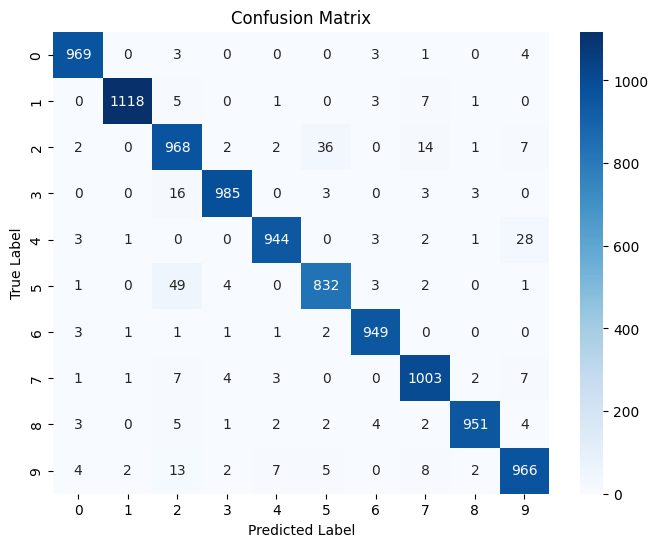

In [37]:
plot_confusion_matrix(true_labels, model_predictions, classes)